# RNN - Insurance

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_excel('../raw_data/daily_data_clean.xlsx', engine='openpyxl')

In [3]:
data = data.drop(columns=['Unnamed: 0', 'date_issue'])

In [4]:
data

,total_amount_claims
0,168
1,346
2,16169
3,28529
4,64135
...,...
915,350720
916,293427
917,333658
918,139824


In [5]:
print("min: ",data['total_amount_claims'].min())
print("max: ",data['total_amount_claims'].max())

min:  31
max:  713904


In [4]:
# data_sept_18 = data[data['date_issue'] < '2018-10-01']
# data_sept_18.max()

date_issue             2018-09-30 00:00:00
total_amount_claims                 686066
dtype: object

In [5]:
# data_oct_18 = data[(data['date_issue'] < '2018-11-01') & (data['date_issue']>'2018-10-01')]
# data_oct_18.max()

date_issue             2018-10-31 00:00:00
total_amount_claims                 334808
dtype: object

In [6]:
data.shape

(920, 1)

In [7]:
min_ = data['total_amount_claims'].min()
max_ = data['total_amount_claims'].max()

data['total_amount_claims'] = [((x - min_) / (max_ - min_)) for x in data['total_amount_claims']]

In [8]:
data

,total_amount_claims
0,0.000192
1,0.000441
2,0.022606
3,0.039920
4,0.089797
...,...
915,0.491248
916,0.410992
917,0.467348
918,0.195823


### Split data

In [9]:
len_ = int(0.8*data.shape[0])

data_train = data[:len_]
data_test = data[len_:]

In [10]:
print(data_train.shape)
print(data_test.shape)

(736, 1)
(184, 1)


### Sequences

In [11]:
def subsample_sequence(data, length):
    
    last_possible = data.shape[0] - length
    
    random_start = np.random.randint(0, last_possible)
    data_sample = data[random_start: random_start+length]
    
    return data_sample

In [12]:
data_subsample = subsample_sequence(data, 10)
data_subsample

,total_amount_claims
815,0.256701
816,0.338060
817,0.352937
818,0.224158
819,0.279838
820,0.184629
821,0.391025
822,0.276109
823,0.277287
824,0.209670


In [13]:
def fillna(X, data_mean):
    # Replace with NaN of the other hours. 
    na = X.mean()
    
    # If the other hours are also nans, then replace with mean value of the dataframe
    na.fillna(data_mean)
    return na

def split_subsample_sequence(data, length, data_mean=None):
    # Little trick to improve the time
    if data_mean is None:
        data_mean = data.mean()
              
    data_subsample = subsample_sequence(data, length)
    y_sample = data_subsample.iloc[data_subsample.shape[0]-1]['total_amount_claims']
    
    if y_sample != y_sample: # A value is not equal to itself only for NaN. So it will be True if y_sample is nan
        X_sample, y_sample = split_subsample_sequence(data, length, data_mean)
        return np.array(X_sample), np.array(y_sample)
    
    X_sample = data_subsample[0:data_subsample.shape[0]-1]
    X_sample = X_sample.fillna(fillna(X_sample, data_mean))
    X_sample = X_sample.values
    
    return np.array(X_sample), np.array(y_sample)

In [14]:
def get_X_y(data, number_of_sequences, length):
    X, y = [], []

    for i in range(number_of_sequences):
        xi, yi = split_subsample_sequence(data, length)
        X.append(xi)
        y.append(yi)
        
    X = np.array(X)
    y = np.array(y)
        
    return X, y

In [26]:
X_train, y_train = get_X_y(data_train, 500, 30)
X_test, y_test = get_X_y(data_test, 100, 30)

In [ ]:
# !pip install tensorflow

In [27]:
print(f'X train size:{X_train.shape}')
print(f'X test size:{X_test.shape}')
print(f'y train size:{y_train.shape}')
print(f'y test size:{y_test.shape}')

X train size:(500, 29, 1)
X test size:(100, 29, 1)
y train size:(500,)
y test size:(100,)


In [ ]:
X_train

In [28]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()

model.add(layers.LSTM(20, activation='tanh'))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dense(1, activation='linear'))

In [29]:
model.compile(loss='mse', 
              optimizer='rmsprop', 
              metrics=['mae', 'mape'])

In [30]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train,
            validation_split=0.2,
            epochs=100, 
            batch_size=16,
            callbacks=[es])

Epoch 1/100
25/25 [==============================] - 3s 41ms/step - loss: 0.0164 - mae: 0.0835 - mape: 266.9972 - val_loss: 0.0141 - val_mae: 0.0784 - val_mape: 449.3033
Epoch 2/100
25/25 [==============================] - 0s 16ms/step - loss: 0.0124 - mae: 0.0768 - mape: 485.7995 - val_loss: 0.0137 - val_mae: 0.0742 - val_mape: 385.7747
Epoch 3/100
25/25 [==============================] - 0s 14ms/step - loss: 0.0149 - mae: 0.0742 - mape: 430.6113 - val_loss: 0.0143 - val_mae: 0.0739 - val_mape: 289.1373
Epoch 4/100
25/25 [==============================] - 0s 15ms/step - loss: 0.0097 - mae: 0.0653 - mape: 414.9932 - val_loss: 0.0125 - val_mae: 0.0730 - val_mape: 386.3169
Epoch 5/100
25/25 [==============================] - 0s 15ms/step - loss: 0.0143 - mae: 0.0731 - mape: 467.0925 - val_loss: 0.0138 - val_mae: 0.0733 - val_mape: 269.3215
Epoch 6/100
25/25 [==============================] - 0s 15ms/step - loss: 0.0100 - mae: 0.0662 - mape: 322.0569 - val_loss: 0.0122 - val_mae: 0.0734 -

In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20)                1760      
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 105       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 1,871
Trainable params: 1,871
Non-trainable params: 0
_________________________________________________________________


In [32]:
model_eval = model.evaluate(X_test, y_test, verbose=0)
print(f'Model Mean Absolute Error {model_eval[1]:.4f}')
print(f'Model Mean Absolute Porcentual Error {model_eval[2]:.4f}')

Model Mean Absolute Error 0.1169
Model Mean Absolute Porcentual Error 55.7532


In [ ]:
# tf.keras.losses.MAPE(
#     y_true, y_pred
# )

#### Prediction

In [33]:
predict = model.predict(X_test)

In [34]:
predict

array([[0.24312711],
       [0.27108467],
       [0.35764173],
       [0.24719729],
       [0.2549387 ],
       [0.3489181 ],
       [0.3942797 ],
       [0.26300493],
       [0.26300493],
       [0.25205803],
       [0.35468993],
       [0.36447686],
       [0.35243675],
       [0.2641001 ],
       [0.369903  ],
       [0.26300493],
       [0.28531978],
       [0.27108467],
       [0.26651087],
       [0.25844154],
       [0.26292005],
       [0.3791258 ],
       [0.3546786 ],
       [0.2638147 ],
       [0.24127091],
       [0.26485988],
       [0.26637736],
       [0.22870083],
       [0.3546786 ],
       [0.26159796],
       [0.20288703],
       [0.23760629],
       [0.3546786 ],
       [0.26667777],
       [0.21870291],
       [0.20685267],
       [0.45756176],
       [0.35007855],
       [0.34293452],
       [0.2401365 ],
       [0.20330295],
       [0.23760627],
       [0.32362542],
       [0.27018037],
       [0.23750004],
       [0.34467646],
       [0.19850928],
       [0.201

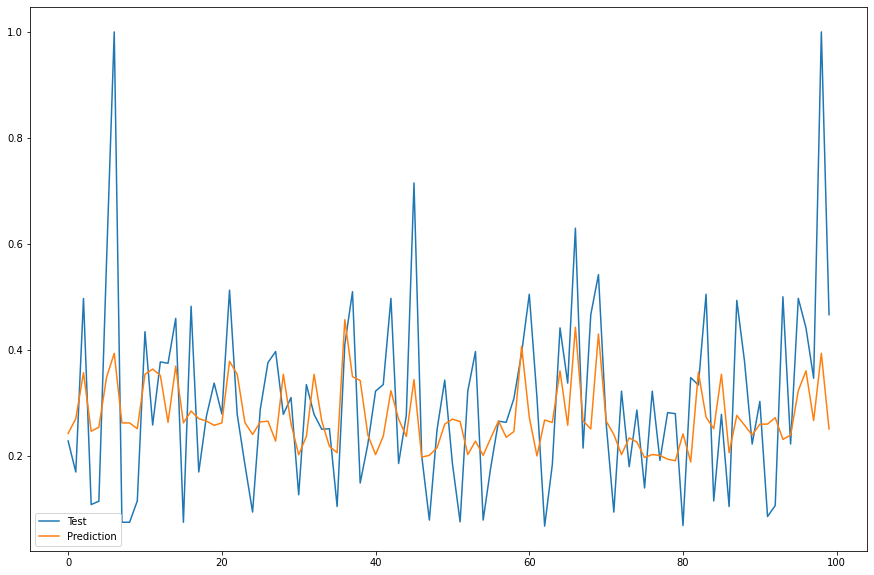

In [35]:
plt.figure(figsize=(15,10))
plt.plot(y_test,label = 'Test')
plt.plot(predict, label = 'Prediction')
plt.legend(loc='best')
plt.show()